In [1]:
import numpy as np
import pandas as pd
import fbprophet
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('input/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
m1 = Prophet()
m1.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [4]:
# 扩展未来的指定天数，默认包含历史数据
future = m1.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [5]:
forecast = m1.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.202479,7.478190,8.925565
3266,2017-01-16,8.527473,7.790848,9.264149
3267,2017-01-17,8.314861,7.615039,9.048334
3268,2017-01-18,8.147459,7.417802,8.846089
3269,2017-01-19,8.159363,7.412282,8.851332


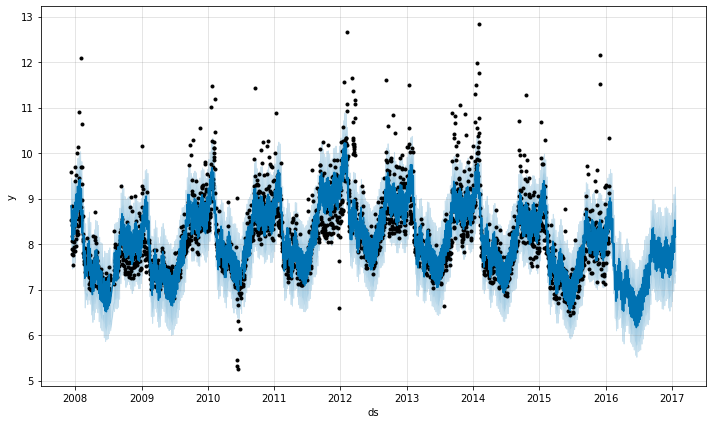

In [6]:
m1.plot(forecast);

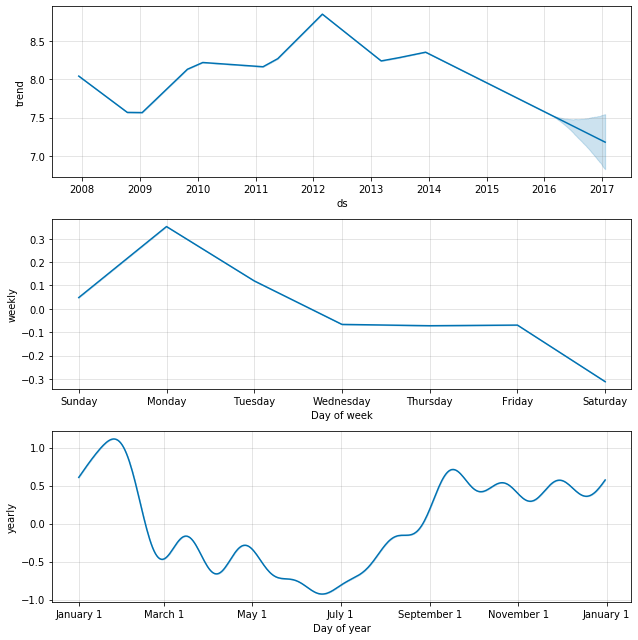

In [7]:
m1.plot_components(forecast);

In [8]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


# 饱和预测
## 预测饱和增长

In [9]:
df = pd.read_csv('input/example_wp_R.csv')
df['y'] = np.log(df['y'])

In [10]:
# 新建一列 cap 来指定承载能力的大小
df['cap'] = 8.5

In [11]:
m2 = Prophet(growth='logistic')
m2.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


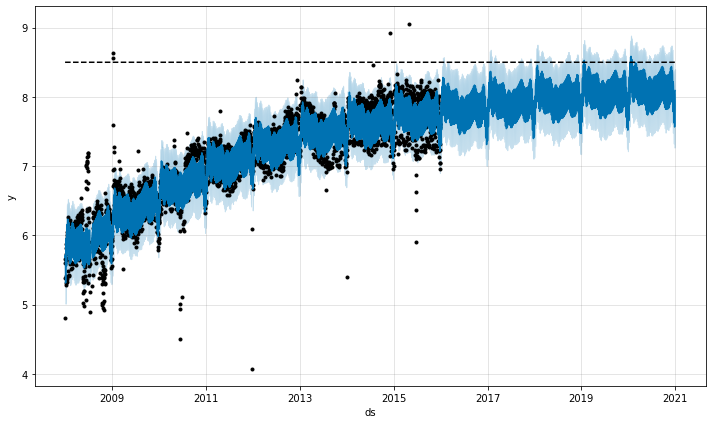

In [12]:
future = m2.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m2.predict(future)
fig = m2.plot(fcst)

## 预测饱和减小

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


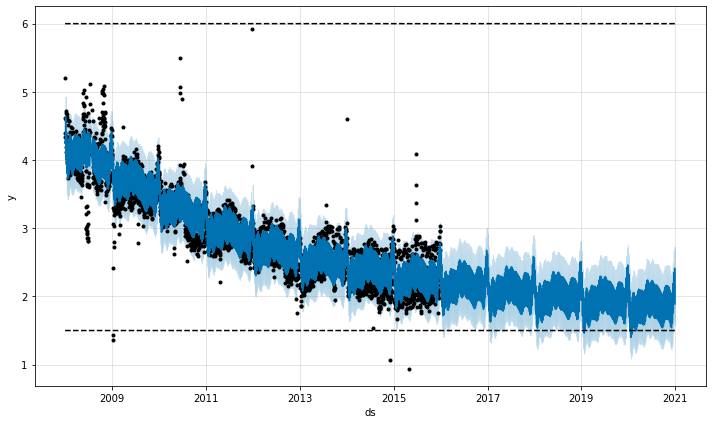

In [13]:
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m3 = Prophet(growth='logistic')
m3.fit(df)
fcst = m3.predict(future)
fig = m3.plot(fcst)

# 趋势突变点
## Prophet 中的自动监测突变点

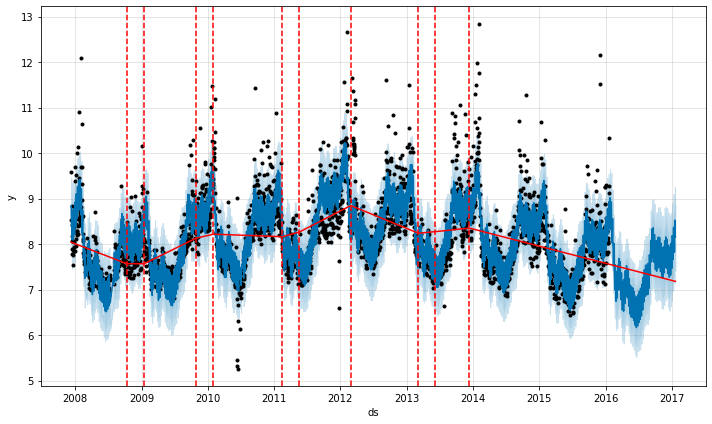

In [14]:
from fbprophet.plot import add_changepoints_to_plot
fig = m1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m1, forecast)

## 调整趋势的灵活性

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


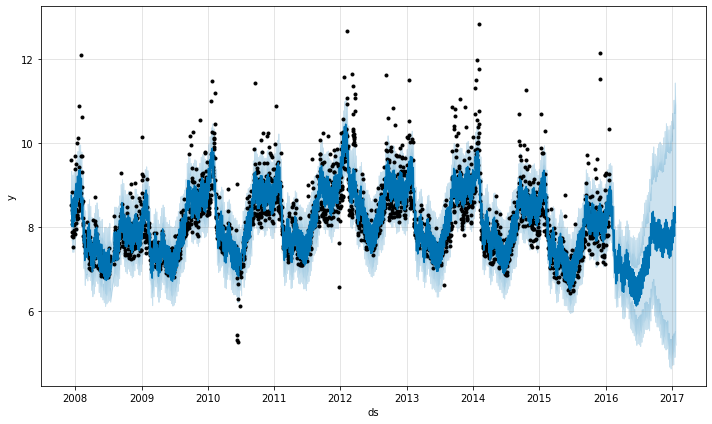

In [15]:
df = pd.read_csv('input/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
 
# changepoint_prior_scale: 正则化
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df)
 
future = m.make_future_dataframe(periods=365)
 
forecast = m.predict(future)
fig = m.plot(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


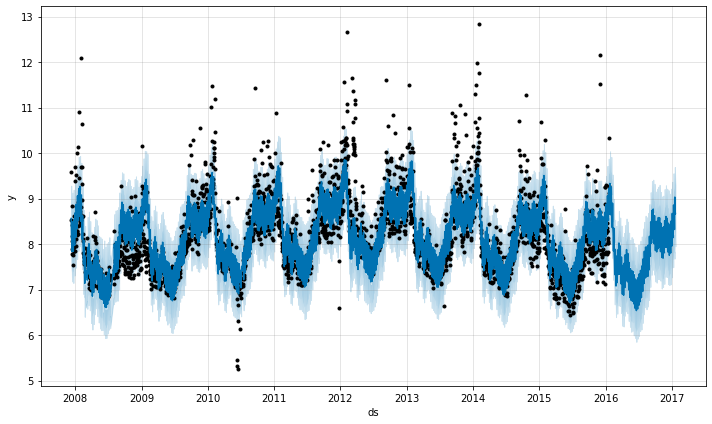

In [16]:
m = Prophet(changepoint_prior_scale=0.001)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

## 指定突变点的位置

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


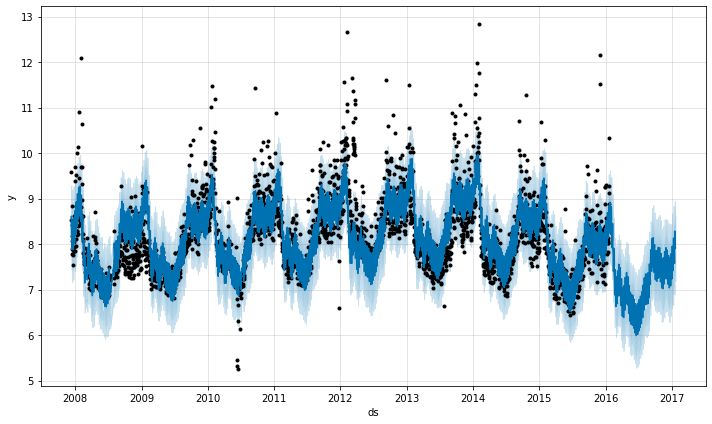

In [17]:
m = Prophet(changepoints=['2014-01-01'])
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

# 季节性，假期效果和回归量
## 对假期和特征事件建模

In [18]:
playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                          '2010-01-24', '2010-02-07', '2011-01-08',
                          '2013-01-12', '2014-01-12', '2014-01-19',
                          '2014-02-02', '2015-01-11', '2016-01-17',
                          '2016-01-24', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1,
})
superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [19]:
df = pd.read_csv('input/example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
 
m = Prophet(holidays=holidays)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
# 假期的最后10行数据
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.222796,1.206278
2191,2014-02-03,1.906262,1.417991
2532,2015-01-11,1.222796,0.000000
2533,2015-01-12,1.906262,0.000000
2901,2016-01-17,1.222796,0.000000
2902,2016-01-18,1.906262,0.000000
2908,2016-01-24,1.222796,0.000000
2909,2016-01-25,1.906262,0.000000
2922,2016-02-07,1.222796,1.206278
2923,2016-02-08,1.906262,1.417991


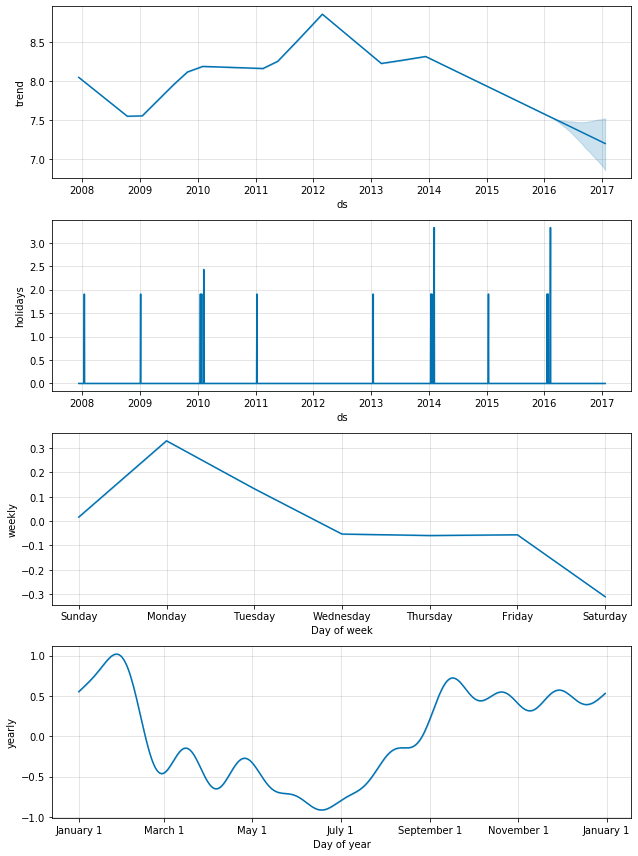

In [21]:
fig = m.plot_components(forecast)

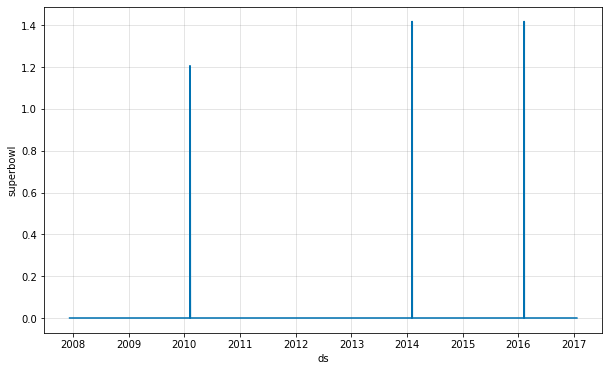

In [22]:
from fbprophet.plot import plot_forecast_component
plot_forecast_component(m, forecast, 'superbowl')

## 季节性的傅里叶级数

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


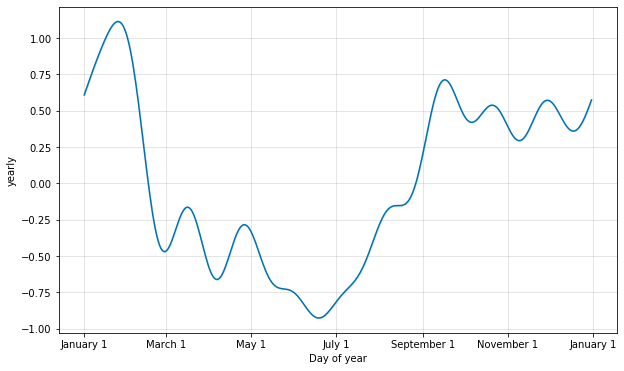

In [23]:
from fbprophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


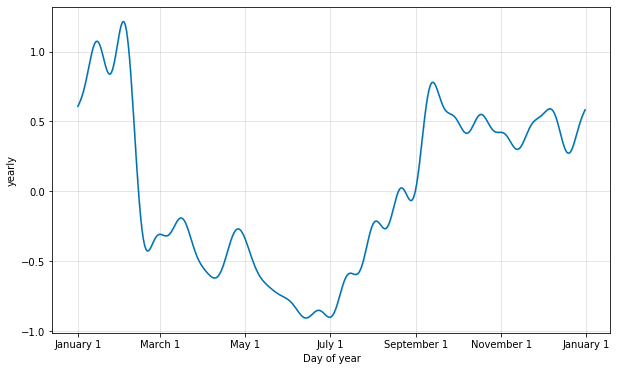

In [24]:
from fbprophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

## 自定义季节性因素

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


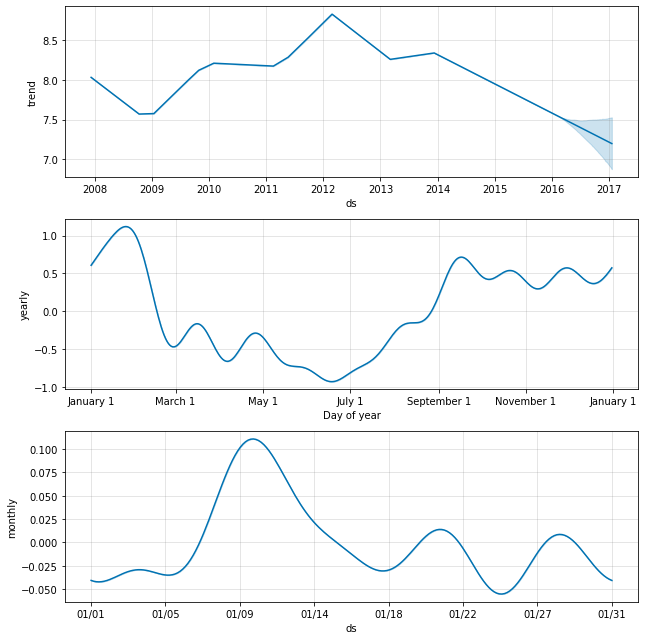

In [25]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

## 对节假日和季节性设定先验规模

In [26]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][['ds', 'playoff', 'superbowl']][-10:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,playoff,superbowl
2190,2014-02-02,1.208439,0.956910
2191,2014-02-03,1.853240,0.996086
2532,2015-01-11,1.208439,0.000000
2533,2015-01-12,1.853240,0.000000
2901,2016-01-17,1.208439,0.000000
2902,2016-01-18,1.853240,0.000000
2908,2016-01-24,1.208439,0.000000
2909,2016-01-25,1.853240,0.000000
2922,2016-02-07,1.208439,0.956910
2923,2016-02-08,1.853240,0.996086


In [27]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

## 附加的回归量

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


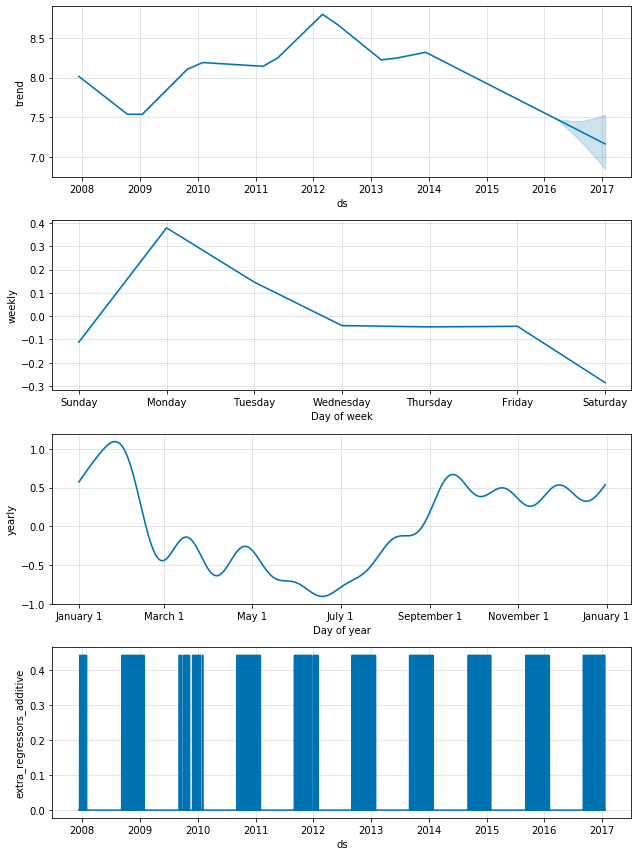

In [28]:
# 判断是否是NFL赛季的周日
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)
 
m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)
 
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)
 
forecast = m.predict(future)
fig = m.plot_components(forecast)

# 乘法季节性

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


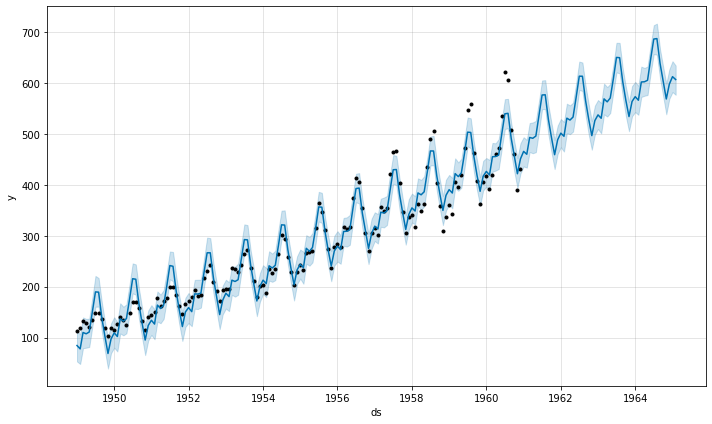

In [29]:
df = pd.read_csv('input/example_air_passengers.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')  # month start frequency
forecast = m.predict(future)
fig = m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


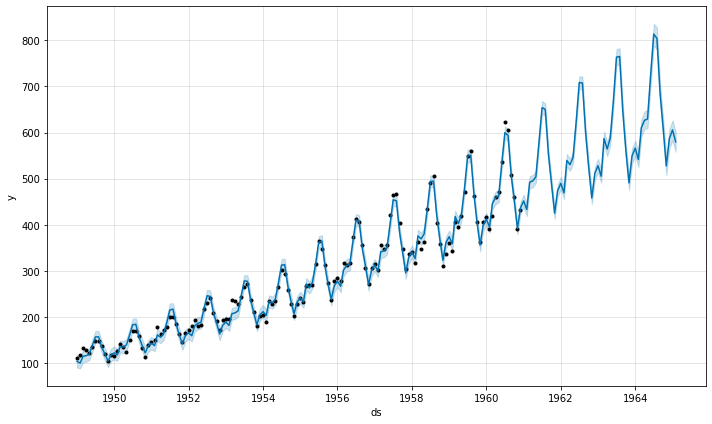

In [30]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

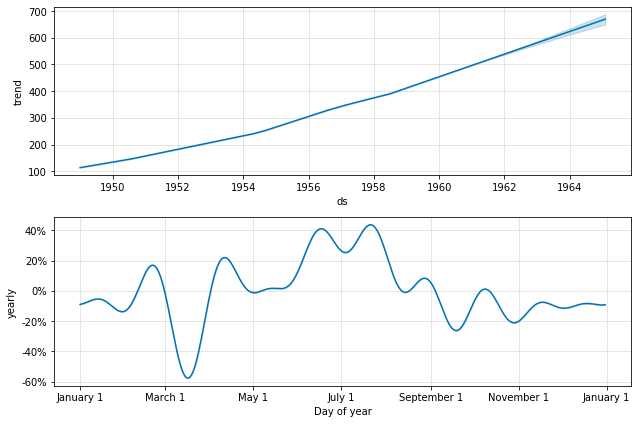

In [31]:
fig = m.plot_components(forecast)

In [32]:
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


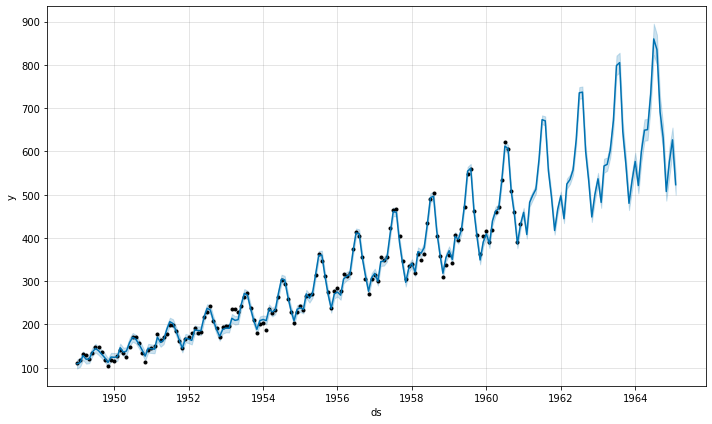

In [33]:
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

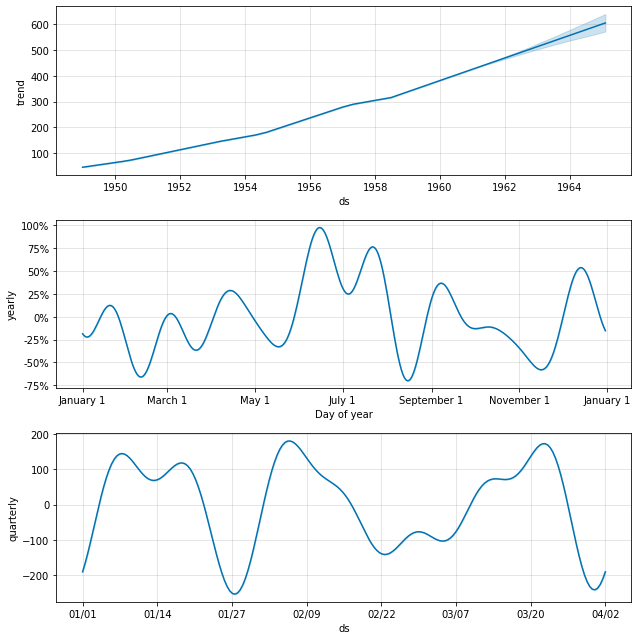

In [34]:
fig = m.plot_components(forecast)

# 预测区间
## 趋势的不确定性

In [35]:
# 预测区间的宽度（默认下，是 80% ）可以通过设置 interval_width 参数来控制
m = Prophet(interval_width=0.95).fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 季节的不确定性

In [36]:
m = Prophet(mcmc_samples=500).fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
# 报错：UnboundLocalError: local variable 'pool' referenced before assignment

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


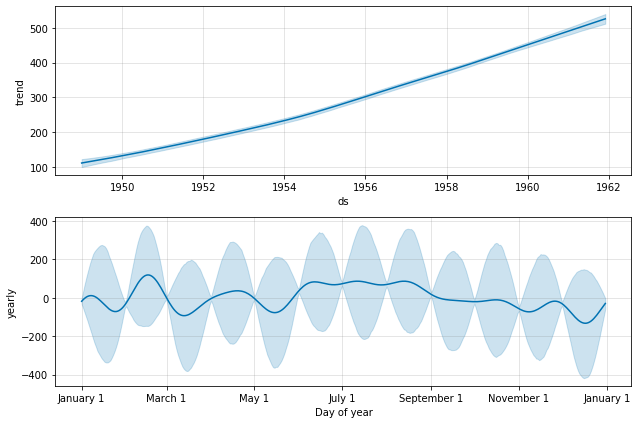

In [37]:
m.plot_components(forecast);

# 非日数据
## 子日数据

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


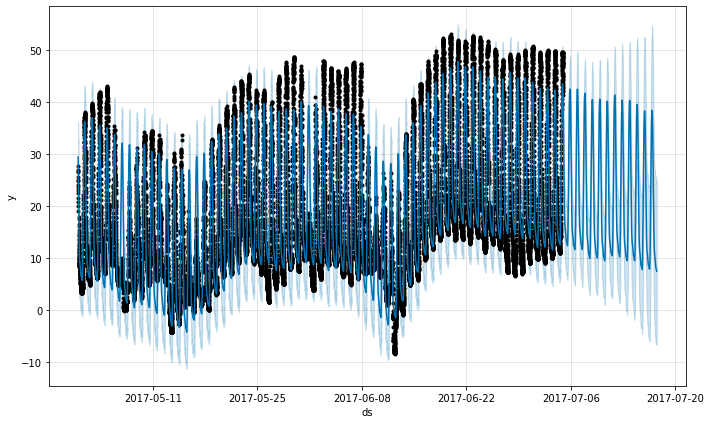

In [38]:
df = pd.read_csv('input/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [39]:
future.tail()

,ds
19016,2017-07-17 08:00:00
19017,2017-07-17 09:00:00
19018,2017-07-17 10:00:00
19019,2017-07-17 11:00:00
19020,2017-07-17 12:00:00


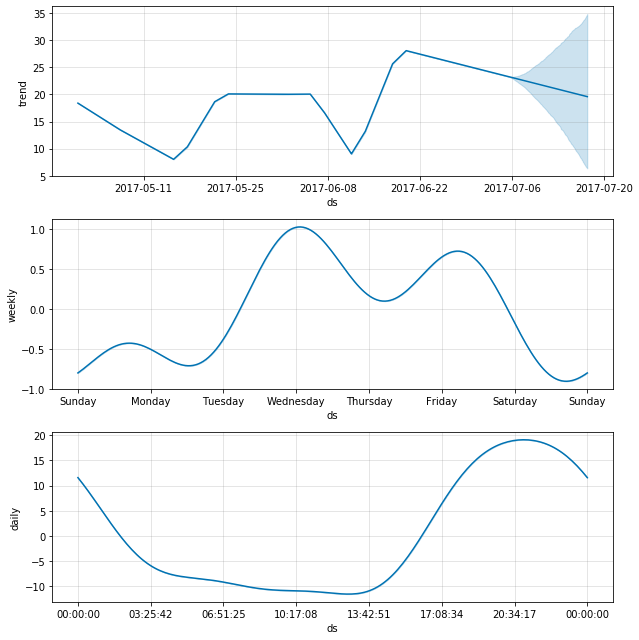

In [40]:
fig = m.plot_components(fcst)

## 有规则间隔的数据

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


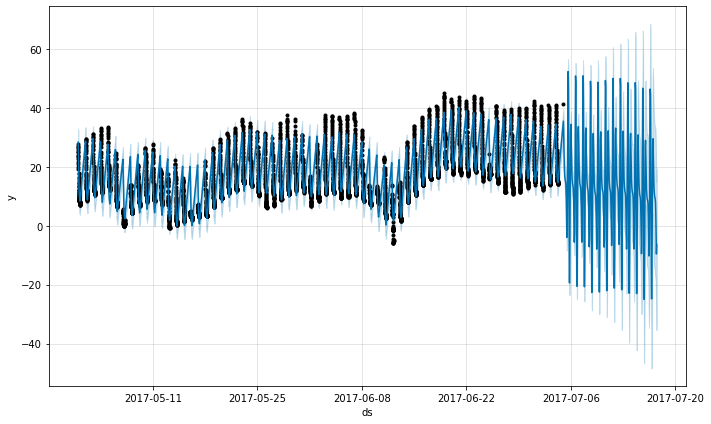

In [41]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
# 只保留每天早上6点之前的数据
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

## 月数据

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


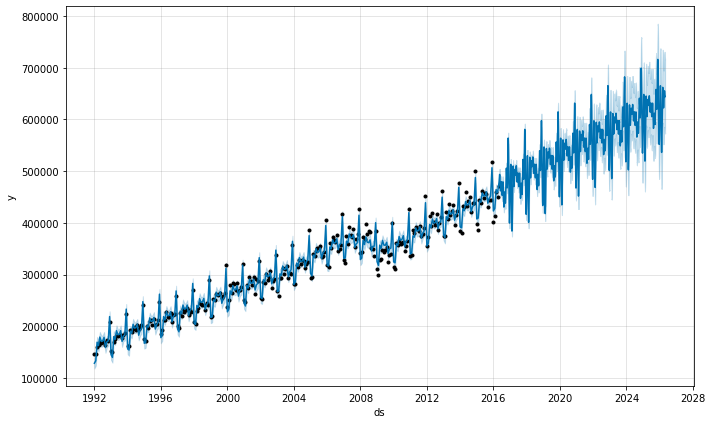

In [42]:
df = pd.read_csv('input/example_retail_sales.csv')
m = Prophet().fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
m.plot(fcst);

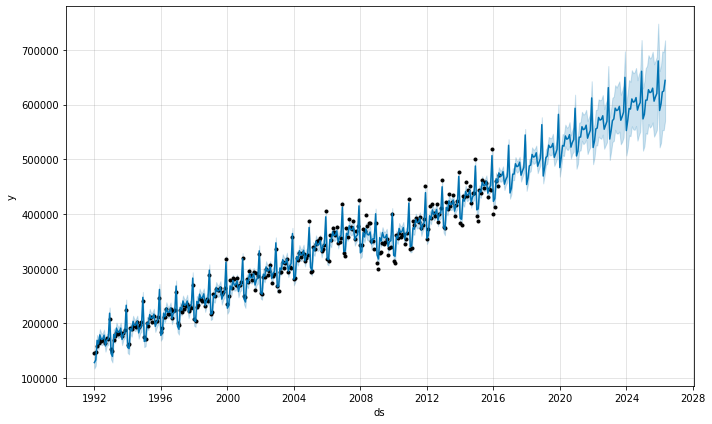

In [43]:
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
m.plot(fcst);

# 诊断

In [44]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 44 forecasts with cutoffs between 1994-02-21 00:00:00 and 2015-05-02 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1994-03-01,190228.293930,189883.503303,190491.798343,192319,1994-02-21
1,1994-04-01,190602.739997,189280.335855,191860.147030,189569,1994-02-21
2,1994-05-01,196522.586224,194005.757309,199224.276524,194927,1994-02-21
3,1994-06-01,198094.412343,193955.566243,202454.691966,197946,1994-02-21
4,1994-07-01,202027.182160,196182.050933,207978.467061,193355,1994-02-21


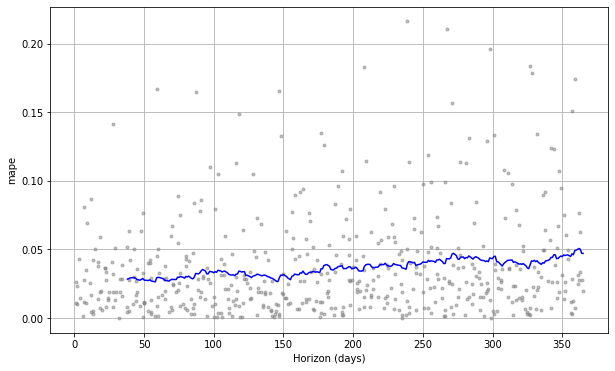

In [45]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')